In [ ]:
import os
import re
import requests
import zipfile
import pandas as pd
from functools import reduce, partial

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize,WhitespaceTokenizer

# typing
from typing import List, Callable, Dict

# Data pipeline
The goal of this section is to convert initial textual input into a numerical format that is compatible with our models.

## Data Loading
Download the dataset and save it to file system.
The dataset is composed by 3 csv files: train, validation and test. These 3 csv files will be loaded directly into 3 different dataframes.

In [ ]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Load the files into different data frames.

In [ ]:
# Be sure all columns have a name
column_names = ['Row', 'Claim', 'Evidence', 'ID', 'Label']

# Load and split the datasets
df_train = pd.read_csv ('dataset/train_pairs.csv', names=column_names, header=0)
df_val = pd.read_csv ('dataset/val_pairs.csv', names=column_names, header=0)
df_test = pd.read_csv ('dataset/test_pairs.csv', names=column_names, header=0)


In [ ]:
df_train.head()

,Row,Claim,Evidence,ID,Label
0,0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


What follows is the countplot of the classes that can be found in the training set.

This is useful for showing that the training set is imbalanced.

<a name="001"></a>

Text(0.5, 1.0, 'Train set labels distribution')

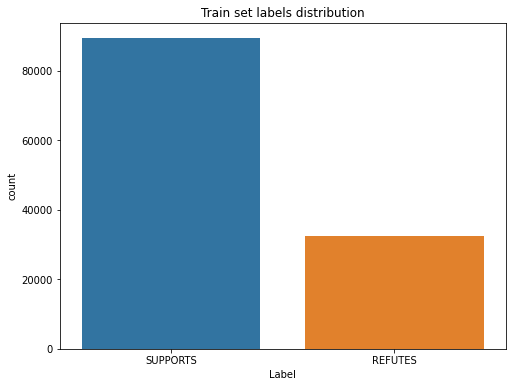

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df_train['Label']).set_title('Train set labels distribution')

The classes are very well balanced in the validation set, and also in the test set.
<a name="003"></a>

Text(0.5, 1.0, 'Validation set labels distribution')

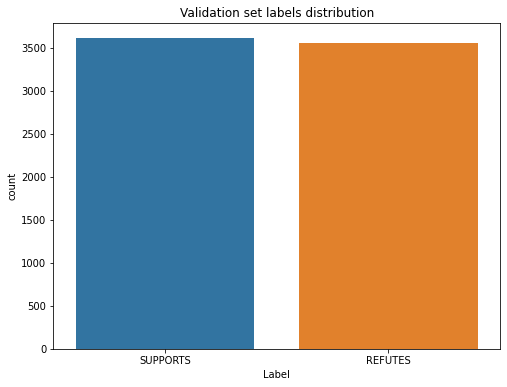

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df_val['Label']).set_title('Validation set labels distribution')

Text(0.5, 1.0, 'Test set labels distribution')

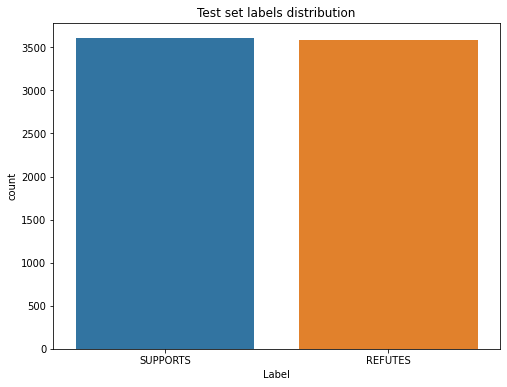

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df_test['Label']).set_title('Test set labels distribution')

The following code is currently not used. However, we left the code here because it represents some of the attempts we made for fighting against the class imbalance problem.

<a name="002"></a>

In [ ]:
# Count the positive and negative labels
label_count = df_train['Label'].value_counts()
pos = label_count['SUPPORTS']
neg = label_count['REFUTES']

# Bias that could be applied to the last Dense layer of the network.
# This should help at least at the beginning of the training, we the model
# has still to learn a lot from the data.
initial_bias = np.log([pos/neg])

# Compute the class_weight dictionary that could be passed to the model .fit function.
total = neg+pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

## Data Pre-processing
Perform text cleaning and tokenization operations.
Start by creating some utility methods that will be used for cleaning the text.

In [ ]:
# Special characters to remove: /(){}[]|@,;
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# Accepted symbols:
# - numbers between 0-9
# - all lower cased letters
# - whitespace, #, + _
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

# - ^ begnning of a string
# - \d any digit
# - \s whitespaces and tabs
BEGINNING_IDS_RE = re.compile('^\d*\s*')

# Remove multiple whitespaces, tabs and newlines
EXTRA_WHITE_SPACE_RE = re.compile('/\s\s+/g')

TAGS_TO_REMOVE = ['-LCB-', '-RCB-', '-LSB-', '-RSB-', '-RRB', '-LRB-']


# The stopwords are a list of words that are very very common but don’t 
# provide useful information for most text analysis procedures.
# Therefore, they will be removed from the dataset
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))


nltk.download('punkt') # necessary for being able to tokenize
nltk.download('wordnet') 
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    """
    Method used for removing most common words

    Parameters
    ----------
    text : str
        The text to process
    
    Returns
    -------
    text : str
        The processed text.
    """
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

def replace_ids(text: str) -> str:
    """
    Method used for removing ids and some whitespaces that could appear
    at the beginning of the text.

    Parameters
    ----------
    text : str
        The text to process
    
    Returns
    -------
    text : str
        The processed text.
    """
    return BEGINNING_IDS_RE.sub('', text)

def lemsent(sentence):
    """
    Method used for lemmatize text.

    Parameters
    ----------
    text : str
        The text to process.
    
    Returns
    -------
    text : str
        The processed text.
    """
    #words = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(str(sentence))]
    words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
    return " ".join(words)

def remove_pos_tags(text: str) -> str:
  '''
  Remove POS tags from the text

  Parameters
  ----------
  text: str
    Text where tags should be removed.

  Returns
  --------
  text: str
    Input text without POS tags
  '''

  for tag in TAGS_TO_REMOVE:
    text = re.sub(tag, '', text)
  return text

def remove_wikipedia_tags(text: str) -> str:
  '''
  Remove Wikipedia tags at the end of a sentence.

  Parameters
  ----------
  text: str
    Text where tags should be removed.

  Returns
  --------
  text: str
    Input text without Wikipedia tags
  '''

  return text.split('.\t')[0]

#List of all the preprocessing methods to be called
GENERIC_PREPROCESSING_PIPELINE = [
                                  remove_wikipedia_tags,
                                  remove_pos_tags,
                                  lower,
                                  replace_special_characters,
                                  filter_out_uncommon_symbols,
                                  #remove_stopwords,
                                  strip_text,
                                  lemsent
                                  ]

EVIDENCES_PREPROCESSING_PIPELINE = GENERIC_PREPROCESSING_PIPELINE
EVIDENCES_PREPROCESSING_PIPELINE.insert(0, replace_ids)
    

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = \
        filter_methods if filter_methods is not None else GENERIC_PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Now we are ready to pre-process the dataset.

In [ ]:
def preprocess_dataset(df: pd.DataFrame) -> pd.DataFrame:
  '''
  Apply the preprocessing operations to the dataframe.

  Parameters
  ----------
  df: pd.DataFrame
    Dataframe to be preprocessed

  Returns
  --------
  df: pd.DataFrame
    Preprocessed dataframe
  '''

  # Replace each sentence with its pre-processed version
  df['Evidence'] = df['Evidence'].apply(
      lambda txt: text_prepare(txt, filter_methods=EVIDENCES_PREPROCESSING_PIPELINE)
      )
  df['Claim'] = df['Claim'].apply(lambda txt: text_prepare(txt))
  
  return df

df_train = preprocess_dataset(df_train)
df_val = preprocess_dataset(df_val)
df_test = preprocess_dataset(df_test)

## Tokenization and vocabularies
Here each set is passed through a tokenization process, which also allows to define the vocabulary of each set and also their vocabulary size. Furthermore the maximum length of a token sequence is defined and the labels are extracted from the sets.

In [ ]:
STARTING_TOKEN = 1 #First value to start the tokenization on (0 is already used as padding value)
QUANTILE = 0.99 #Quantile used to reduce the max number of tokens and save space

def get_tokenizer(corpus: List[str])->Dict[str,int]:
  '''
  Create a tokenization dictionary that associates an integer to each word.

  Parameters:
  -----------
  corpus: List[str]
    Text to examine searching for new words to add into the dictionary.

  Returns:
  --------
  words_to_tokens: Dict[str,int]
    A filled dictionary that associates an integer to each word
  '''

  #Initialize the dictionary
  words_to_tokens = {}

  #Fill dictionary with new words
  for text in corpus:
    words = text.split()
    for word in words:
      if not word in words_to_tokens:
        #Add a new word with incremental token number
        words_to_tokens[word] = len(words_to_tokens)+STARTING_TOKEN

  return words_to_tokens

def tokenize(word: str,
             words_to_tokens: Dict[str,int])->int:
  '''
  Get the integer value of a given token.

  Parameters:
  -----------
  word: str
    Token
  words_to_tokens: Dict[str,int]
    Tokenization dictionary

  Returns:
  -------
  int:
    Value associated to the token
  '''

  return words_to_tokens[word]

def detokenize(token:int,
               words_to_tokens: Dict[str,int])->str:
  '''
  Get the token-word of a given token-value.

  Parameters:
  -----------
  token: int
    Tokenized word
  words_to_tokens: Dict[str,int]
    Tokenization dictionary

  Returns:
  -------
  str:
    Word associated to the token-value
  '''

  val_list = list(words_to_tokens.values())
  key_list = list(words_to_tokens.keys())

  position = val_list.index(token)

  return key_list[position]

def tokenize_string(string: str,
                    words_to_tokens: Dict[str,int],
                    max_length: int)->List[int]:

  '''
  Get the tokenized sequence of a string of separated tokens (document/sentence).

  Parameters:
  string: str
    String of separated tokens (document or sentence)
  words_to_tokens: Dict[str,int]
    Tokenization dictionary
  max_length: int
    Tokenization length

  Returns:
    List[int]:
      A list of token-values where each one is the tokenized value of a token
      int the input-string.
      The list is padded if its length is below the max_length.
      The list is truncated if its length is above the max_length.
  '''

  tokens = string.split()
  tokenized_sequence = [tokenize(token, words_to_tokens)  for token in tokens]
  length_diff = max_length-len(tokenized_sequence)

  if length_diff==0: # Return the same sequence if it has the requested size
    return tokenized_sequence
  elif length_diff<0: # Return the truncated sequence if it exceeds the requested size
    return tokenized_sequence[0:max_length]
  else: # Return the padded sequence if it has an inferior size than the expected one
    return np.pad(tokenized_sequence, (0, length_diff), 'constant').tolist()

def label_to_binary(label: str) ->int:
  '''
  Convert a label into a binary value (0 or 1).

  Parameters
  ----------
  label: str
    Label to be converted.

  Returns
  ----------
  int
    Binary conversion of the label.
  '''

  if label=="SUPPORTS":
    return 1
  elif label=="REFUTES":
    return 0
  else:
    raise "Invalid label."

#Define corpus
train_text_claim = df_train["Claim"].tolist()
train_text_evidence = df_train["Evidence"].tolist()
val_text_claim = df_val["Claim"].tolist()
val_text_evidence = df_val["Evidence"].tolist()
test_text_claim = df_test["Claim"].tolist()
test_text_evidence = df_test["Evidence"].tolist()

#Define labels
train_labels = df_train["Label"].tolist()
val_labels = df_val["Label"].tolist()
test_labels = df_test["Label"].tolist()

#Token dictionary
corpus = train_text_claim+train_text_evidence+val_text_claim+val_text_evidence+test_text_claim+test_text_evidence
tokens_dictionary = get_tokenizer(corpus)

#Vocabulary
tokens_vocabulary = tokens_dictionary.keys()

#Vocab size
vocabulary_size = len(tokens_vocabulary)+STARTING_TOKEN #+1 to include padding value

#Max length of a token sequence
n_tokens = [len(doc.split()) for doc in corpus]
max_length = int(np.quantile(n_tokens,QUANTILE))

#Tokenized sets
train_claims_tokenized = np.array(list(map(lambda string: tokenize_string(string, tokens_dictionary,max_length),train_text_claim)))
train_evidences_tokenized = np.array(list(map(lambda string: tokenize_string(string, tokens_dictionary,max_length),train_text_evidence)))

val_claims_tokenized = np.array(list(map(lambda string: tokenize_string(string, tokens_dictionary,max_length),val_text_claim)))
val_evidences_tokenized = np.array(list(map(lambda string: tokenize_string(string, tokens_dictionary,max_length),val_text_evidence)))

test_claims_tokenized = np.array(list(map(lambda string: tokenize_string(string, tokens_dictionary,max_length),test_text_claim)))
test_evidences_tokenized = np.array(list(map(lambda string: tokenize_string(string, tokens_dictionary,max_length),test_text_evidence)))

#Tokenized labels
train_labels_tokenized = np.array(list(map(label_to_binary,train_labels)))
val_labels_tokenized = np.array(list(map(label_to_binary,val_labels)))
test_labels_tokenized = np.array(list(map(label_to_binary,test_labels)))

#Models

This macro section is related with everything that concerns creating, training, testing and evaluating the NN models.

##Constants and utilities

Defining a set of variables, whose values are fixed, that determines how the model will be created, trained, tested and evaluated. 

In [ ]:
#Sample values
BATCH_SIZE = 32
EMBEDDING_SIZE = 64 #Embedding size for a token and subsequently an entire sentence
EPOCHS = 50 #Number of training epochs

DENSE_UNITS = 64 #Max number of units to use in Dense layers
MLP_LAYERS = 1 #Number of Dense layers used in the MLP sentence embedding
DENSE_CLASSIFICATION_LAYERS = 2 #Number of Dense layers used in the classification

L2_RATE = 0.08 #Value used in L2 regularization
DROPOUT_RATE = 0.3 #Dropout value for Dropout layers
LEARNING_RATE = 1e-3

SENTENCE_EMBEDDING_MODE = "RNN last" #This must be one between "RNN last", "RNN mean", "Bag of vectors", "MLP"
RNN_MODEL = "LSTM" #This must be one between "GRU" and "LSTM"
MERGE_MODE = "Concatenate" #This must be one between "Concatenate", "Sum" and "Mean"
APPLY_COSINE_SIMILARITY = True #Simple extension task using cosine similarity
CLAIM_VERIFICATION_EVALUATION = True #Evaluate using the claim verification evaluation method (if True)

OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#Binary cross entropy and binary accuracy are adopted since this is a binary classification task
LOSS = tf.keras.losses.BinaryCrossentropy()
METRICS = [tf.keras.metrics.BinaryAccuracy()]

# Model common training information, early stopping is used in case of overfitting
training_info = {
    'verbose': 1,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=10,
                                                restore_best_weights=True)]
}

# Model common prediction information
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

##Inputs

Defining the Input layers for keras.

In [ ]:
claims_input = keras.Input(shape=(max_length), name="claims")
evidences_input = keras.Input(shape=(max_length), name="evidences")

##Token embedding

Defining the building of the token embedding layer, the one responsible for token embedding.

In [ ]:
def token_embedding_layer(vocab_size: int,
                    embedding_size: int,
                    max_length: int,
                    layer_name: str,
                    pre_trained_weights=None,
                    train=True) ->keras.layers.Layer:
  
  '''
  Define a keras layer for embedding.

  Parameters:
  -----------
  vocab_size: int
    Vocabulary size
  embedding_size: int
    Embedding size
  max_length: int
    Max number of tokens
  layer_name: str
    Name to be assigned to the embedding layer
  pre_trained_weights
    Pre-trained weights to initialize the layer (optional)
  train: bool
    Decide if training or not the weights (optional)

  Returns:
  --------
  layer: keras.layers.Layer
    The generated embedding layer
  '''

#Use pre-trained weights for the embedding (not used)
  if pre_trained_weights is None:
    layer = layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_size, 
        input_length=max_length,
        mask_zero=True, #Apply mask to padding
        trainable=train,
        name=layer_name
        )
  
  else:
    layer = layers.Embedding(
          input_dim=vocab_size, 
          output_dim=embedding_size, 
          input_length=max_length,
          weights=[pre_trained_weights],
          mask_zero=True, #Apply mask to padding
          trainable=train,
          name=layer_name
          )
  
  return layer

##Sentence embedding

Here all possible methods for the sentence embedding step are implemented. They are: 

1. "RNN last" (implemented inside the "RNN_Sentence_Embedding" class)
2. "RNN mean" (implemented inside the "RNN_Sentence_Embedding" class)
3. "Bag of vectors" (implemented inside the "Bag_of_vectors_Sentence_Embedding" class)
4. "MLP" (implemented inside the MLP_Sentence_Embedding class)

In [ ]:
#The embedding of a sentence is derived through a RNN layer
class RNN_Sentence_Embedding(keras.layers.Layer):
  def __init__(self,
               rnn_size: int,
               layer_name: str,
               mode: str,
               rnn_model: str,
               dropout: float,
               l2: keras.regularizers.l2):
    '''
    Parameters:
    -----------
    rnn_size: int
      Number of units for RNN layers
    layer_name: str
      Name to assign to current layer
    mode: str
      Mode (one between 'RNN last' and 'RNN mean')
    rnn_model: str
      RNN model to use inside the Bidirectional layer (one between 'GRU' and 'LSTM')
    dropout: float
      Dropout rate
    l2: keras.regularizers.l2
      L2 regularizer
    '''

    super(RNN_Sentence_Embedding, self).__init__(name=layer_name)

    self.mode = mode #One between "RNN last" and "RNN mean"
    self.rnn_model = rnn_model
    
    dropout_value = dropout
    if dropout is None:
      dropout_value = 0

    #Common RNN parameters
    rnn_params= {"units":rnn_size,
                 "return_sequences":True,
                 "return_state":True,
                 "activation":"tanh",
                 "kernel_regularizer": l2,
                 "dropout": dropout_value
                 }

    #Define a GRU or LSTM layer
    if rnn_model=="GRU":
      layer = layers.GRU(**rnn_params)
    elif rnn_model=="LSTM":
      layer = layers.LSTM(**rnn_params)
    else:
      raise Exception("Invalid RNN model. Use 'GRU' or 'LSTM'")

    #Define a Bidirectional layer containing the RNN model defined above
    self.rnn = layers.Bidirectional(layer,merge_mode="ave") #Take the average of correspondent forward and backward hidden states
    print(f'\tAdding bidirectional rnn with {rnn_size} units')

    #Define an average layer
    if self.mode=="RNN last":
      self.average_layer = layers.Average()
      print(f'\tAdding average layer')
    elif self.mode=="RNN mean":
      self.average_layer = layers.GlobalAveragePooling1D()
      print(f'\tAdding global average pooling layer')
    else:
      raise Exception("Invalid Mode. Use 'RNN Last' or 'RNN Mean'")

  def compute_mask(self, inputs, mask=None):
    #Overriding: return a null mask after this sentence embedding layer
    return None

  def call(self, inputs, mask=None):

    #Apply the Bidirectional layer and take the outputs

    if self.rnn_model=="GRU":
      whole_seq_output, forward_h, backward_h = self.rnn(inputs,mask=mask)
    elif self.rnn_model=="LSTM":
      whole_seq_output, forward_h, forward_c, backward_h, backward_c = self.rnn(inputs,mask=mask)
    


    if self.mode=="RNN last":
      #Take the average between last forward and backward hidden states. (The
      #goal is to remain linear with the bilinear "merge_mode" defined before)
      return self.average_layer([forward_h, backward_h])
    elif self.mode=="RNN mean":
      #Take the average between all the hidden states
      return self.average_layer(whole_seq_output,mask=mask)

#The embedding of a sentence is defined as a mean of all the embeddings of its tokens
class Bag_Of_Vectors_Sentence_Embedding(keras.layers.Layer):
  def __init__(self, layer_name: str):
    '''
    Parameters:
    ----------
    layer_name: str
      Name to assign to current layer
    '''

    super(Bag_Of_Vectors_Sentence_Embedding, self).__init__(name=layer_name)

    #Define a layer for computing the mean
    self.average_pooling_layer = layers.GlobalAveragePooling1D()
    print(f'\tAdding global average pooling layer')

  def compute_mask(self, inputs, mask=None):
    #Overriding: return a null mask after this sentence embedding layer
    return None

  def call(self, inputs, mask=None):
    #Compute the mean of all the embedding values
    return self.average_pooling_layer(inputs,mask=mask)

#The embedding of a sentence is derived through a series of Dense layers
class MLP_Sentence_Embedding(keras.layers.Layer):
  def __init__(self, 
               max_dense_units: int,
               n_layers: int, 
               layer_name: str, 
               max_tokens: int, 
               embedding_size: int, 
               dropout=None,
               l2=None):
    '''
    Parameters:
    -----------
    max_dense_units: int
      Max number of units to use in a Dense layer
    n_layers: int
      Number of Dense layers
    layer_name: str
      Name to assign to current layer
    max_tokens: int 
      Max number of tokens
    embedding_size: int
      Embedding size
    dropout: float
      Dropout rate
    l2: keras.regularizers.l2
      L2 regularizer
    '''

    super(MLP_Sentence_Embedding,self).__init__(name=layer_name)

    #A list of layers to be applied
    self.layer_list = []
    
    #Add a reshape layer to reshape input from (batch_size, max_tokens, embedding_size) to (batch_size, max_tokens*embedding_size)
    reshape_layer = layers.Reshape((max_tokens*embedding_size,))
    self.layer_list.append(reshape_layer)
    
    #Add a series of Dense layers
    for i in range(n_layers):
      n_units = self.number_of_units(i, n_layers, max_dense_units, embedding_size)
      dense_layer = layers.Dense(
          units=n_units,
          activation='tanh',
          kernel_regularizer=l2
          )
      self.layer_list.append(dense_layer)
      print(f'\tAdding dense layer with {n_units} units')

      #Add dropout layer if requested
      if dropout is not None:
        dropout_layer = layers.Dropout(dropout)
        self.layer_list.append(dropout_layer)
        print(f'\tAdding dropout layer')
      
  def compute_mask(self, inputs, mask=None):
    #Overriding: return a null mask after this sentence embedding layer
    return None
  
  def number_of_units(self, 
                      layer_number: int, 
                      max_layer_number: int,
                      max_dense_units: int,
                      embedding_size: int)->int:
    '''
    Determine the number of units to use inside a Dense layer.

    Parameters:
    -----------
    layer_number: int
      Number of the Dense layer in the sequence
    max_layer_number: int
      Max number of Dense layer in the sequence
    max_dense_units: int
      Max number of units accepted
    embedding_size: int
      Embedding size

    Returns:
    --------
    n: int
      Number of units to use.
    '''

    #Last layer must have a number of units equal to the embedding size
    if layer_number == max_layer_number - 1:
      n = embedding_size
    #Each layer has half of the units of the one that preceeds it
    else:
      n = max_dense_units / 2**layer_number
      if(n < embedding_size):
        #The number of units cannot be less than the embedding size
        n = embedding_size
    
    return n

    return n

  def call(self, x, mask=None):

    #Apply all the layers defined in the initialization
    for layer in self.layer_list:
      x = layer(x)
    
    return x

def sentence_embedding_layer(mode: str, 
                             rnn_model: str, 
                             dense_units: int, 
                             mlp_layers: int, 
                             layer_name: str, 
                             max_tokens: int, 
                             embedding_size: int, 
                             dropout: float, 
                             l2: keras.regularizers.l2) ->keras.layers.Layer:
  '''
  Build the sentence embedding layer.

  Parameters:
  -----------
  mode: str
    Sentence embedding mode
  rnn_model: str
    RNN model to use in 'RNN last' or 'RNN mean' modes
  dense_units: int
    Max number of units to adopt in 'MLP' sentence embedding mode
  mlp_layers: int
    Number of layers to adopt in 'MLP' sentence embedding mode
  layer_name: str
    Name to assign to the current layer
  max_tokens: int
    Max number of tokens
  embedding_size: int
    Embedding size
  dropout: float
    Dropout rate
  l2: keras.regularizers.l2
    L2 regularizer

  Returns:
  --------
  layer: keras.layers.Layer
    The sentence embedding layer.
  ''' 

  print('Sentence Embedding layers creation started')

  if mode=="RNN last" or mode=="RNN mean":
    layer = RNN_Sentence_Embedding(embedding_size,layer_name,mode,rnn_model,dropout,l2)
  elif mode=="Bag of vectors":
    layer = Bag_Of_Vectors_Sentence_Embedding(layer_name)
  elif mode=="MLP":
    layer = MLP_Sentence_Embedding(dense_units, mlp_layers, layer_name, max_tokens, embedding_size, dropout, l2)
  else:
    raise Exception("Invalid Mode.")
  
  print('Sentence Embedding layers creation completed')

  return layer

##Merge 

This section defines all the possible layers to handle the "merge" step of the model, where the embedded sentences of the claims and the evidences must be merged in one of the possible way:

1. Using concatenation;
2. Summing their values;
3. Taking a mean of their values.

In [ ]:
def concatenate(layer_name: str)->keras.layers.Layer:

  '''
  Return a layer for inputs concatenation.

  Parameters:
  -----------
  layer_name:str
    Name to assign to current layer

  Returns:
  --------
  layer: keras.layers.Layer
    Concatenation layer
  '''

  return layers.Concatenate(name=layer_name)

def sum(layer_name: str)->keras.layers.Layer:
  '''
  Return a layer for summing the inputs.

  Parameters:
  -----------
  layer_name:str
    Name to assign to current layer

  Returns:
  --------
  layer: keras.layers.Layer
    Add layer
  '''

  return layers.Add(name=layer_name)

def mean(layer_name: str)->keras.layers.Layer:
  '''
  Return a layer for averaging the inputs.

  Parameters:
  -----------
  layer_name:str
    Name to assign to current layer

  Returns:
  --------
  layer: keras.layers.Layer
    Average layer
  '''

  return layers.Average(name=layer_name)

def merge_layer(merge_mode: str, layer_name:str)->keras.layers.Layer:
  '''
  Return a layer for merging inputs.

  Parameters:
  -----------
  merge_mode: str
    A merge mode between 'Concatenate', 'Sum' or 'Mean'
  layer_name: str
    Name to assign to current layer

  Returns:
  --------
  layer: keras.layers.Layer
    Merge layer
  '''

  if merge_mode=="Concatenate":
    return concatenate(layer_name)
  elif merge_mode=="Sum":
    return sum(layer_name)
  elif merge_mode=="Mean":
    return mean(layer_name)
  else:
    raise Exception("Invalid merge mode.")

##Classification

Defining basic layer (Dense) for the classification step.

In [ ]:
def dense_classification_layer(dense_units: int,
                               activation_function: str,
                               layer_name: str,
                               last: bool,
                               l2=None) ->keras.layers.Layer:
  '''
  Return a Dense layer for the classification task.

  Parameters:
  ------------
  dense_units: int
    Number of units to use in Dense layers
  activation_function: str
    Activation function to adopt
  layer_name: str
    Name to assign to current layer
  last: bool
    Whether the current layer is the last one or not
  l2: keras.regularizers.l2
    L2 regularizer

  Returns:
  --------
  layer: keras.layers.Layer
    Dense classification layer.
  '''

  #Use sigmoid activation function and a single unit if it is the last Dense layer to allow binary classification
  if last:
    layer= layers.Dense(1,
                        activation="sigmoid",
                        name=layer_name)
    
  else:
    layer= layers.Dense(units=dense_units,
                        activation=activation_function,
                        kernel_regularizer=l2,
                        name=layer_name)
  
  return layer

##Build model

###Building layers

In [ ]:
def build_layers(vocab_size: int,
                 embedding_size: int,
                 max_tokens: int,
                 sentence_embedding_mode: str,
                 dense_units: int,
                 mlp_layers: int,
                 dense_classification_layers: int,
                 rnn_model: str,
                 dropout=None,
                 l2=None):
  
  '''
  Build and return all the layers used to build the entire model.

  Parameters:
  ----------
  vocab_size: int
    Vocabulary size
  embedding_size: int
    Embedding size
  max_tokens: int
    Max number of tokens
  sentence_embedding_mode: str
    Mode used for sentence embedding
  dense_units: int
    Max number of units to use in Dense layers,
    in case of "MLP" mode for sentence embedding
  mlp_layers: int
    Number of Dense layers,
    in case of "MLP" mode for sentence embedding
  dense_classification_layers: int
    Number of Dense layers for the classification step
  rnn_model: str
    RNN model, in case of of RNN sentence embedding mode
  dropout: float
    Dropout rate
  l2: keras.regularizers.l2
    L2 regularizer

  Returns:
  --------
  Tuple containing the requested layers of the model.
  '''

  #Build the token embedding layer
  layer_embedded_tokens = token_embedding_layer(vocab_size,
                                                embedding_size,
                                                max_tokens,
                                                "token_embedding")
  #Build the sentence embedding layer
  layer_embedded_sentences = sentence_embedding_layer(sentence_embedding_mode,
                                                      rnn_model,
                                                      dense_units,
                                                      mlp_layers,
                                                      "sentences_embedding",
                                                      max_tokens,
                                                      embedding_size,
                                                      dropout,
                                                      l2)
  #Build the merge layer
  layer_merge = merge_layer(MERGE_MODE,"merge")

  #Build classification layers
  classification_layers = []
  
  for i in range(dense_classification_layers):
    units = dense_units/2**i #Each layer has half of the units of the one that preceeds it
    is_last_layer = False
    layer_name = "intermediate_classification_"+str(i+1)

    if i == (dense_classification_layers - 1):
      is_last_layer = True
      layer_name = "final_classification"
    
    classification_layers.append(
        dense_classification_layer(units,
                                   "tanh",
                                   layer_name,
                                   is_last_layer,
                                   l2)
        )
    
    #Add dropout layers if requested
    if dropout is not None and not is_last_layer:
      classification_layers.append(layers.Dropout(dropout))
  
  return (layer_embedded_tokens, layer_embedded_sentences, layer_merge, classification_layers)

###End-to-end model

In this part all the layers are combined to create the final model.

In [ ]:
def build_model(built_layers,
                claims_input,
                evidences_input,
                dense_classification_layers):

  layer_embedded_tokens, layer_embedded_sentences, layer_merge, classification_layers = built_layers

  claims_tokens_embedded = layer_embedded_tokens(claims_input)
  evidences_tokens_embedded = layer_embedded_tokens(evidences_input)

  claims_sentences_embedded = layer_embedded_sentences(claims_tokens_embedded)
  evidences_sentences_embedded = layer_embedded_sentences(evidences_tokens_embedded)

  classification_input = layer_merge([claims_sentences_embedded,evidences_sentences_embedded])

  #Cosine similarity extension step:
  if APPLY_COSINE_SIMILARITY:
    layer_cosine_similarity = layers.Dot(axes=(1), normalize=True,name="cosine_similarity") #Normalize=True will compute the cosine similarity (see documentation)
    layer_concatenation = layers.Concatenate(name="cosine_similarity_concat")
    cosine_similarity = layer_cosine_similarity([claims_sentences_embedded,evidences_sentences_embedded])
    classification_output = layer_concatenation([classification_input,cosine_similarity])

  else:
    classification_output = classification_input

  for layer in classification_layers:
    classification_output = layer(classification_output)

  # Instantiate an end-to-end model
  model = keras.Model(
      inputs=[claims_input, evidences_input],
      outputs=[classification_output]
  )


  return model

###Build and compile model

The following cell makes use of the previous methods to build and compile a full model, based on the variables set in the "Constants and utilities" section.

In [ ]:
def build_and_compile(vocab_size: int,
                      embedding_size: int,
                      max_tokens: int,
                      sentence_embedding_mode: str,
                      dense_units: int,
                      mlp_layers: int,
                      rnn_model: str,
                      claims_input: keras.layers.Layer,
                      evidences_input: keras.layers.Layer,
                      dense_classification_layers: int,
                      optimizer: keras.optimizers,
                      loss: tf.keras.losses,
                      metrics: list,
                      dropout=None,
                      l2=None) ->keras.Model:

  '''
  Build and compile a new model.

  Parameters:
  -----------
  vocab_size: int
    Vocabulary size
  embedding_size: int
    Embedding size
  max_tokens: int
    Max number of tokens
  sentence_embedding_mode: str
    Mode used for sentence embedding
  dense_units: int
    Max number of units to use in Dense layers,
    in case of "MLP" mode for sentence embedding
  mlp_layers: int
    Number of Dense layers,
    in case of "MLP" mode for sentence embedding
  rnn_model: str
    RNN model, in case of of RNN sentence embedding mode
  claims_input: keras.layers.Layer
    Claims input layer
  evidences_input: keras.layers.Layer
    Evidences input layer
  dense_classification_layers: int
    Number of Dense layers for the classification step
  optimizer: keras.optimizers
    Optimizer of the model
  loss: tf.keras.losses
    Loss function to train the model
  metrics: List
    List of metrics to track model's progression
  dropout: float
    Dropout rate
  l2: keras.regularizers.l2
    L2 regularizer

  Returns:
  --------
  model: keras.Model
    The built and compiled model.
  '''

  #Build the required layers
  built_layers = build_layers(vocab_size,
                              embedding_size,
                              max_tokens,
                              sentence_embedding_mode,
                              dense_units,
                              mlp_layers,
                              dense_classification_layers,
                              rnn_model,
                              dropout,
                              l2)
  
  #Combine the layers into a full model
  model = build_model(built_layers,
                      claims_input,
                      evidences_input,
                      dense_classification_layers)

  model_compile_info = {
      'optimizer': optimizer,
      'loss': loss,
      'metrics': metrics,
  }

  #Compile the model
  model.compile(**model_compile_info)

  return model

Sentence Embedding layers creation started
	Adding bidirectional rnn with 64 units
	Adding average layer
Sentence Embedding layers creation completed


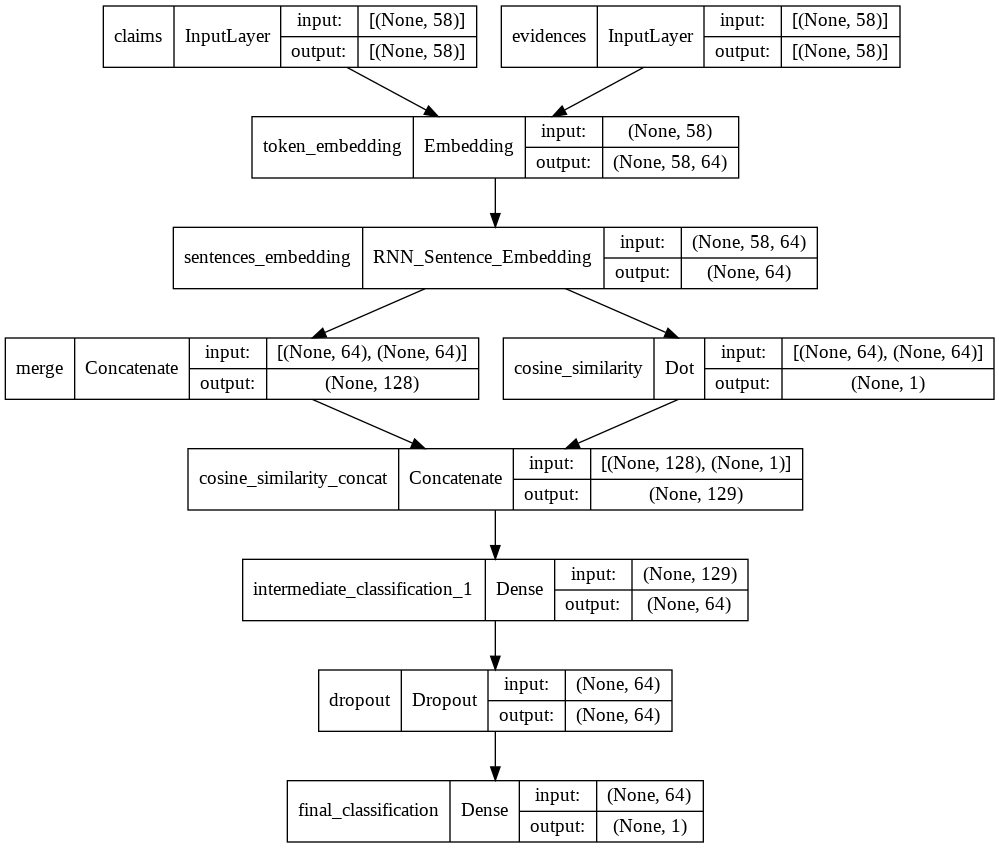

In [ ]:
#Build and compile the model
model = build_and_compile(vocabulary_size,
                          EMBEDDING_SIZE,
                          max_length,
                          SENTENCE_EMBEDDING_MODE,
                          DENSE_UNITS,
                          MLP_LAYERS,
                          RNN_MODEL,
                          claims_input,
                          evidences_input,
                          DENSE_CLASSIFICATION_LAYERS,
                          OPTIMIZER,
                          LOSS,
                          METRICS,
                          DROPOUT_RATE,#None, DROPOUT_RATE
                          keras.regularizers.l2(L2_RATE))#None, keras.regularizers.l2(L2_RATE)

#Show architecture
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True, expand_nested=True)

##Train model

All the methods revolving around the training of the model are implemented in this section.

In [ ]:
def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    print(history.history)
    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    val_accuracies = history_data['val_binary_accuracy']
    best_val_epoch = np.argmax(val_accuracies)
    best_val_acc = val_accuracies[best_val_epoch]

    print(f'Best validation accuracy: {best_val_acc} obtained at epoch: {best_val_epoch}')

    plt.show()


def train_model(model: keras.Model,
                claims_train: np.ndarray,
                evidences_train: np.ndarray,
                labels_train: np.ndarray,
                claims_val: np.ndarray,
                evidences_val: np.ndarray,
                labels_val: np.ndarray,
                training_info: dict) -> keras.Model:

    '''
    Train the model and plot valuable information.

    Parameters:
    -----------
    model: keras.Model
      Model to be trained
    claims_train: np.ndarray
      Training set of the claims
    evidences_train: np.ndarray
      Training set of the evidences
    labels_train: np.ndarray
      Training set of the labels
    claims_val: np.ndarray
      Validation set of the claims
    evidences_val: np.ndarray
      Validation set of the evidences
    labels_val: np.ndarray
      Validation set of the labels
    training_info: dict
      Training data

    Returns:
    --------
    model: keras.Model
      Trained model
    '''

    print("Start training! \nParameters: {}".format(training_info))

    '''
    total = neg+pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    '''

    history = model.fit(x={"claims":claims_train,"evidences":evidences_train},
                        y=labels_train,
                        # class_weight=class_weight,
                        validation_data=({"claims":claims_val,"evidences":evidences_val},labels_val),
                        **training_info)
    
    print("Training completed! Showing history...")

    show_history(history)

    return model

Start training! 
Parameters: {'verbose': 1, 'epochs': 50, 'batch_size': 32, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f82e48dad10>]}
Epoch 1/50
3805/3805 [==============================] - 98s 22ms/step - loss: 0.8459 - binary_accuracy: 0.7341 - val_loss: 0.7840 - val_binary_accuracy: 0.5040
Epoch 2/50
3805/3805 [==============================] - 80s 21ms/step - loss: 0.4662 - binary_accuracy: 0.8106 - val_loss: 0.5472 - val_binary_accuracy: 0.7228
Epoch 3/50
3805/3805 [==============================] - 80s 21ms/step - loss: 0.3940 - binary_accuracy: 0.8454 - val_loss: 0.6069 - val_binary_accuracy: 0.7121
Epoch 4/50
3805/3805 [==============================] - 80s 21ms/step - loss: 0.3715 - binary_accuracy: 0.8556 - val_loss: 0.5716 - val_binary_accuracy: 0.7327
Epoch 5/50
3805/3805 [==============================] - 84s 22ms/step - loss: 0.3564 - binary_accuracy: 0.8614 - val_loss: 0.6241 - val_binary_accuracy: 0.7171
Epoch 6/50
3805/3805 [=============================

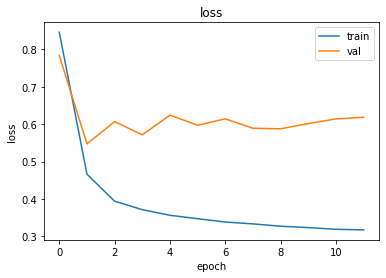

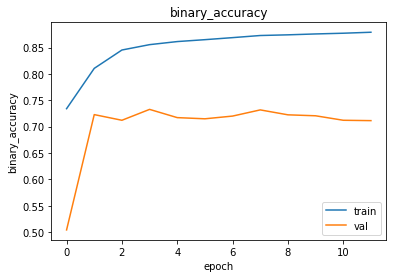

In [ ]:
#Execute training on the generated model
model = train_model(model,
            train_claims_tokenized,
            train_evidences_tokenized,
            train_labels_tokenized,
            val_claims_tokenized,
            val_evidences_tokenized,
            val_labels_tokenized,
            training_info)

##Test model

In [ ]:
def consecutive_claims(tokenized_claims_list: np.ndarray)->list:

  '''
  Generate a list containing the numbers of consecutive element of the list
  given in input that are equal.

  Parameters:
  ----------
  tokenized_claims_list: np.ndarray
    List of claims

  Returns:
  --------
  consecutive_claims_list: list
    Number of consecutive equal claims

  Example:
  -------
  Input:
    ["Claim 1", "Claim 1", "Claim 2", "Claim 2", "Claim 2", "Claim 3]
  Output:
    [2,3,1]
  '''

  n_claims = tokenized_claims_list.shape[0]

  consecutive_claims_list = []

  current_claim = tokenized_claims_list[0]
  current_sum = 1

  for i in range(1,n_claims):
    if np.array_equal(current_claim, tokenized_claims_list[i]):
      current_sum+=1
    else:
      consecutive_claims_list.append(current_sum)

      current_claim = tokenized_claims_list[i]
      current_sum=1
  consecutive_claims_list.append(current_sum)

  return consecutive_claims_list

def majority_vote(votes:np.ndarray)->int:
  '''
  Return a majority vote given a list of votes.

  Parameters:
  ----------
  votes: np.ndarray
    List of binary votes
  
  Returns:
  -------
  value: int
    Majority binary vote
  '''

  zeros = (votes==0).sum()
  ones = (votes==1).sum()

  return 0 if zeros>=ones else 1

def check_labels_consistency(labels: np.ndarray)->bool:
  '''
  Check if a set of labels is consistent (all equal)

  Parameters:
  ----------
  labels: np.ndarray
    List of binary labels
  
  Returns:
  -------
  bool
    Consistency
  '''

  return np.max(labels) == np.min(labels)

def claim_verification_selection(claims_test: np.ndarray,
                                 labels_test: np.ndarray,
                                 test_predictions: np.ndarray):

  '''
  Select predictions by applying the majority vote to those ones sharing
  the same initial claim.

  Parameters:
  ----------
  claims_test: np.ndarray
    Test set of the claims
  labels_test: np.ndarray
    Test set of the labels
  test_predictions: np.ndarray
    Predicted labels

  Returns:
  --------
  reduced_predictions: np.ndarray
    Selected predictions using majority vote
  reduced_labels: np.ndarray
    Selected true labels
  '''

  consecutive_claims_list = consecutive_claims(claims_test)

  reduced_predictions = np.zeros(len(consecutive_claims_list))
  reduced_labels = np.zeros(len(consecutive_claims_list))

  start=0
  for index, n_consecutives in enumerate(consecutive_claims_list):

    labels = labels_test[start:start+n_consecutives]
    if check_labels_consistency(labels):
      reduced_labels[index] = labels[0]
    else:
      print("Inconsistency found!")
      for j in range(start,start+n_consecutives):
        print("Claim {}: {}".format(j-start+1,test_text_claim[j]))
        print("Evidence {}: {}".format(j-start+1,test_text_evidence[j]))
        print("Label {}: {}".format(j-start+1,test_labels[j]))
        print("\n")
      
      start+=n_consecutives
      continue

    votes = test_predictions[start:start+n_consecutives]
    vote = majority_vote(votes)
    reduced_predictions[index]=vote

    start+=n_consecutives

  return reduced_predictions, reduced_labels

#Threshold is higher than 0.5 to tackle class imbalance in the training set,
#where 1 values are three times more common than 0 values.
def round_to_label(prediction: float,
                   threshold=0.65)->int:
  '''
  Round a prediction from [0,1] to {0,1}.

  Parameters:
  ----------
  prediction: float
    Predicted value
  threshold: float
    Rounding threshold

  Returns:
  -------
  int
    Predicted label (0 or 1)    
  '''

  if prediction<threshold:
    return 0
  else:
    return 1

def predict_data(model: keras.Model,
                 claims_test: np.ndarray,
                 evidences_test: np.ndarray,
                 prediction_info: dict) -> np.ndarray:

    '''
    Predict labels on the test set.

    Parameters:
    -----------
    model: keras.Model
      Trained model
    claims_test: np.ndarray
      Test set of the claims
    evidences_test: np.ndarray
      Test set of the evidences
    prediction_info: dict
      Predictiond data info

    Returns:
    --------
    predictions: np.ndarray
      Predicted values
    '''

    print('Starting prediction: \n{}'.format(prediction_info))

    predictions = model.predict(x={"claims":claims_test,"evidences":evidences_test}, **prediction_info)
    return predictions

def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):
  
    '''
    Evaluate metrics on the predictions.

    Parameters:
    ----------
    predictions: np.ndarray
      Predicted values
    y: np.ndarray
      True labels
    metrics: List[Callable]
      Metrics to compute
    metric_names: List[str]
      Names of the metrics to compute

    Returns:
    -------
    Metric info of all computed metrics.
    '''
    
    assert len(metrics) == len(metric_names)
    
    print(f'Prediction evaluation started...')

    metric_info = {}
    for metric, metric_name in zip(metrics, metric_names):
        
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info

def test_model(model: keras.Model,
               claims_test: np.array,
               evidences_test: np.array,
               labels_test: np.array,
               prediction_info: dict,
               claim_verification_evaluation: bool):
  
    '''
    Test the model and compute the metrics.

    Parameters:
    ----------
    model: keras.Model
      Trained model
    claims_test: np.array
      Test set of the claims
    evidences_test: np.array
      Test set of the evidences
    labels_test: np.array
      Test set of the labels
    prediction_info: dict
      Predictiond data info
    claim_verification_evaluation: bool
      Whether to use the evaluation with majority vote or not

    Returns:
    --------
    Metric info of all computed metrics;
    Predicted labels.
    '''
        
    predictions = predict_data(model,
                               claims_test,
                               evidences_test,
                               prediction_info)

    #Reshape predictions from (Batch,1) to (Batch)
    predictions = np.reshape(predictions,(predictions.size))

    #Round each probability into a label (0 or 1)
    test_predictions = np.array(list(map(round_to_label,predictions)))

    # Evaluation
    metrics = [
        partial(f1_score, average='macro'),
        partial(f1_score, average='micro'),
        partial(f1_score, average='weighted'),
        partial(accuracy_score)
    ]

    metric_names = [
        "macro_f1",
        "micro_f1",
        "weighted_f1",
        "accuracy"
    ]

    #Use majority vote system
    if claim_verification_evaluation:
      reduced_predictions, reduced_labels = claim_verification_selection(claims_test, labels_test,test_predictions)
      metric_info = evaluate_predictions(predictions=reduced_predictions,
                                        y=reduced_labels,
                                        metrics=metrics,
                                        metric_names=metric_names)

    else:
      metric_info = evaluate_predictions(predictions=test_predictions,
                                        y=labels_test,
                                        metrics=metrics,
                                        metric_names=metric_names)

    return metric_info, test_predictions

In [ ]:
#Compute predictions and metrics info
metric_info, y_pred = test_model(model,
                                 test_claims_tokenized,
                                 test_evidences_tokenized,
                                 test_labels_tokenized,
                                 prediction_info,
                                 CLAIM_VERIFICATION_EVALUATION)

Starting prediction: 
{'batch_size': 32, 'verbose': 1}
225/225 [==============================] - 6s 7ms/step
Prediction evaluation started...


##Evaluate model

This part contains methods to evaluate and plot model's performances.

In [ ]:
def show_f1_scores(metric_info):
    """
    Method for creating a list of labels that will be used for testing.
    
    Parameters
    -------
    metric_info : dict
        Dictionary that contains the f1 scores
    
    """
    print()
    print('F1 SCORES:')
    print(f'  macro: {metric_info["macro_f1"]}')
    print(f'  micro: {metric_info["micro_f1"]}')
    print(f'  weighted: {metric_info["weighted_f1"]}')
    print()

def show_accuracy_score(metric_info):
  '''
  Method to show the accuracy score of the predicted labels.

  Parameters
  -------
  metric_info : dict
      Dictionary that contains the accuracy_score
  '''

  print("Accuracy score:")
  print(metric_info["accuracy"])
  print()

def show_classification_report(y_true, y_pred):
    """
    Method that prints the classification report
    
    Parameters
    -------
    y_true : np.array
        Array of true labels
    y_pred : np.array
        Array of predicted labels
    """

    print(classification_report(
        y_true, 
        y_pred,
        ))

def show_confusion_matrix(y_true, y_pred):
    """
    Method that shows the confusion matrix.
    
    Parameters
    -------
    y_true : np.array
        Array of true labels
    y_pred : np.array
        Array of predicted labels
    """
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize='true', 
        cmap=plt.cm.Blues, 
        values_format=".2f",
        xticks_rotation='vertical',
        ax=ax)


F1 SCORES:
  macro: 0.7163537001530016
  micro: 0.7167498865183841
  weighted: 0.7163424721993267

              precision    recall  f1-score   support

           0       0.70      0.75      0.73      3583
           1       0.73      0.68      0.71      3606

    accuracy                           0.72      7189
   macro avg       0.72      0.72      0.72      7189
weighted avg       0.72      0.72      0.72      7189

Accuracy score:
0.716749886518384



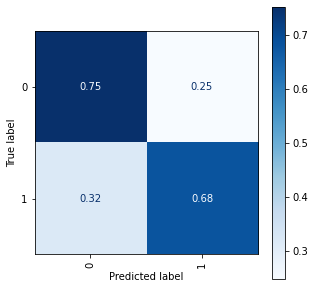

In [ ]:
#Show scores
show_f1_scores(metric_info)
show_classification_report(test_labels_tokenized, y_pred)
show_accuracy_score(metric_info)
show_confusion_matrix(test_labels_tokenized, y_pred)

In [ ]:
text_prepare('14	The series finale aired August 28 , 2013 .')

'the series finale air august 28 2013'

# Discussion and Error Analysis
In this part there is a small summary of the tests we have done, and the explanation of some choices we have made.

Ultimately, there are some considerations about the final selected model performances.

## Data pre-processing
We noticed that the original datasets were relatively dirty, and they required some cleaning before using them as inputs of the models.

**Firstly**, we made some standard operations, e.g., removed unwanted punctuation, lower cased everything, removed special characters, etc....

**Secondly**, we applied specific actions for datasets cluttering removal. In particular:
* we noticed that each **evidence** was starting with a number (most likely the ID of the evidence) and a tabulation character. We removed all of these occurences in all the dataset evidences. Example:
~~~
# Original Sentence
14	The series finale aired August 28 , 2013 .

 # Processed Sentence
 The series finale aired August 28 , 2013 .
~~~

* almost all the evidences terminate with a series of tags that are not really relevant for the classification task, and we decided to remove them. Example:
~~~
# Original Sentence
5	It stars Ray Winstone in his first role in a costume drama .	Ray Winstone	Ray Winstone
 
 # Processed Sentence
It stars Ray Winstone in his first role in a costume drama .
~~~
* Some evidences contain unwated POS tagging symbols that we decided to discard. Example:
~~~
# Original Sentence
 Shailene Diann Woodley -LRB- born November 15 , 1991 -RRB- is an American actress .

 # Processed Sentence (-LRB- and -RRB- removed)
 Shailene Diann Woodley born November 15 , 1991 is an American actress .
~~~

**Thirdly**, we applied stemming, so as to reduce the complexity of the data and normalize it.

**Additionally**, we also removed **stopwords** from the dataset.
After a lot of testing, we discovered that this was causing 2 major issues:
* **inconsistences**: after the pre-processing, some claims had the **same descriptions**, but **different labels**. 
For example, in the original dataset we have the following claims:
~~~
SZA's music combines elements from different genres. (SUPPORT)
SZA's music does not combine elements from different genres. (REFUTES)
~~~
After the pre-processing, which was also consisting in stopwords removal, the results were the same, but with different labels:
~~~
szas music combine element different genre (SUPPORT)
szas music combine element different genre (REFUTES)
~~~
* **duplicates**: for the same reasons explained above, some dataset rows were duplicated (e.g., same claim and same evidence).

Therefore, we eventually decided to avoid the stopwords removal, and we remarked an important improvement in the validation accuracy during the training phase (between 5 and 10%).

**Finally**, we made some data analysis and noticed that the training dataset is not balanced, as it is depicted in [THIS](#001) plot. Whereas, the validation and the test set are quite balanced, as shown [HERE](#003).

### **WARNING**: the pre-processing of the data can take 5-10 mins to complete. This is mainly related to the stemming operation applied.


## Model creation and tuning
After having prepared the data, we proceeded to create the model.

#### **The baseline model**
There are several parameters to tune, and the possible combination of them is relatively large.

In order to reduce the number of possible combinations, we initially looked for a **baseline model** by tuning:
* the number of dense layers in the *classification part* of the model, and their number of units
* the embedding size
* the batch size

During these attemtps, the **sentence embedding mode**, the input **merge mode**, and the use of **cosine similarity** were unaltered. The aforementioned parameters were considered only after the baseline model was found.

Without any regularization technique the model was suffering from **overfitting**. Therefore, we applied the following techniques:
 1. added the **dropout** layer. Initially only after the *classification* part of the model, and then also in the *sentence embedding part*.
 2. similarly to the previous point, we also added the **l2** regularizer
 3. **early stopping**

We also tested some techniques against **class imbalance** that we noticed in the training set, like changing the initial bias value for the last dense layer, and giving to the classes a different weight (more details can be found [HERE](#002)). Unfortunately, **these techniques did not really improve the results**. For this reason, we decide to remove them from the final model. 

We eventually coped with this problem by changing the threshold for deciding the final prediction labels (more details on this later).

#### **Parameter tuning**
After the baseline model was found, we tried different combination of the following parameters: 
* **Sentence embedding**: we observed very similar performances by changing this parameter. However, the one that performed **slightly** better than the other is *RNN Last*.
* **Merge mode**: as for the preovious parameter, we did not notice huge differences in the model performances by changing the merge mode. The one whose performances are **slightly** better is *Concatenate*.
* **Cosine similarity**: adding this feature to the model actually **boosts the final model performance**. When the cosine similarity is NOT computed, the model is slower to train and less accurate.

## Error analysis
The training dataset is **highly unbalanced**: 1-labels are three times more common than 0-labels.
This fact was causing very bad performances at test time.

For this reason, we changed the threshold used for deciding the final class of a prediction. This allowed us to improve the final model results on the test set.
<br /><br /><br />
An important remark is that the model is able to train just for a few epochs before seeing a **drop in the validation performances**. 

Although we applied regularization techniques, our thought is that we were not really able to completely overcome the **overfitting** problem, and this is most likely related to architectural and data issues.

Additionally, we tried to reduce as much as possible the complexity of the model (e.g., reduced the number of hidden units, reduced the embedding size, etc....), but in this case we noticed an **underfitting** problem.

Finally, our consideration is that we can't really improve the model without doing some kind of changes (see next section for some proposals), and that we have found the best model that we could.

## Possible improvements
There are several techniques that could be used for improving the model performances, and what follows is a brief list of some of them: 
* **Gather more data**: this is probably the most difficult, yet the most effective, thing we could do. In this way we could reduce the class imbalance, and improve the model learning thanks to the increased number of samples.
* **Data augmentation**: this technique is very useful and commonly applied in several branches of machine learning and deep learning, and it is typically very beneficial for the models. 
* **Attention and transformers**: attention mechanims and transformers could be very useful for improving the word representations, and for letting the model to focus its attention on relevant parts of the inputs.
* **Architectures**: better architectures could be used for implementing different and more complex sentence embedding mechanisms.